In [6]:
import os
os.chdir("C:\\Users\\numam\\Desktop\\data\\dataset\\building_satellite")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Desktop\\dataset\\building_satellite'

In [18]:
import os
from PIL import Image

input_dir = "C:\\Users\\numam\\Desktop\\data\\dataset\\building_satellite"
target_dir = "C:\\Users\\numam\\Desktop\\data\\dataset\\building_mask"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

inp=[]

for i in range(30):
    for j in input_img_paths:
        inp.append(j)
input_img_paths=inp

out=[]

for i in range(30):
    for j in target_img_paths:
        out.append(j)
target_img_paths=out

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 2100
C:\Users\numam\Desktop\data\dataset\building_satellite\0_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\0_label.jpg
C:\Users\numam\Desktop\data\dataset\building_satellite\10_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\10_label.jpg
C:\Users\numam\Desktop\data\dataset\building_satellite\11_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\11_label.jpg
C:\Users\numam\Desktop\data\dataset\building_satellite\12_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\12_label.jpg
C:\Users\numam\Desktop\data\dataset\building_satellite\13_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\13_label.jpg
C:\Users\numam\Desktop\data\dataset\building_satellite\14_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\14_label.jpg
C:\Users\numam\Desktop\data\dataset\building_satellite\15_image.png | C:\Users\numam\Desktop\data\dataset\building_mask\15_label.jpg
C:\Users\numam\Desktop\data\dataset\building_sa

In [ ]:
import os

input_dir = "C:\\Users\\numam\\Desktop\\data\\dataset\\building_satellite"
target_dir = "C:\\Users\\numam\\Desktop\\data\\datasett\\building_mask"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)



print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

In [2]:
a=[]
b=[]

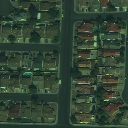

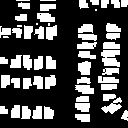

In [19]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [12]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class Building_imgs(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x/255, y/255

In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

In [24]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
random.Random(70).shuffle(input_img_paths)
random.Random(70).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Building_imgs(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = Building_imgs(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [7]:
train_gen.__getitem__(1)

(array([[[[0.13333334, 0.20392157, 0.16078432],
          [0.17254902, 0.23137255, 0.17254902],
          [0.28627452, 0.34117648, 0.23529412],
          ...,
          [0.09411765, 0.1882353 , 0.14509805],
          [0.11764706, 0.21176471, 0.15686275],
          [0.1254902 , 0.21568628, 0.16078432]],
 
         [[0.10588235, 0.18039216, 0.14509805],
          [0.12941177, 0.19607843, 0.15294118],
          [0.15294118, 0.20784314, 0.15686275],
          ...,
          [0.10588235, 0.19607843, 0.15294118],
          [0.11372549, 0.20784314, 0.15294118],
          [0.11764706, 0.21176471, 0.15686275]],
 
         [[0.11764706, 0.19215687, 0.15294118],
          [0.13333334, 0.20784314, 0.16078432],
          [0.14117648, 0.2       , 0.15294118],
          ...,
          [0.11764706, 0.20392157, 0.15294118],
          [0.11372549, 0.20392157, 0.15686275],
          [0.12156863, 0.21568628, 0.15686275]],
 
         ...,
 
         [[0.13725491, 0.21960784, 0.16862746],
          [0.15686

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("Builing_Segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
48/48 [==============================] - 337s 7s/step - loss: 1.5826 - val_loss: 2.1157
Epoch 2/15
48/48 [==============================] - 355s 7s/step - loss: 0.6463 - val_loss: 0.7165
Epoch 3/15
48/48 [==============================] - 322s 7s/step - loss: 0.4557 - val_loss: 0.7467
Epoch 4/15
48/48 [==============================] - 289s 6s/step - loss: 0.4219 - val_loss: 0.7937
Epoch 5/15
48/48 [==============================] - 332s 7s/step - loss: 0.3985 - val_loss: 0.7874
Epoch 6/15
48/48 [==============================] - 314s 7s/step - loss: 0.3226 - val_loss: 0.6942
Epoch 7/15
48/48 [==============================] - 321s 7s/step - loss: 0.3259 - val_loss: 0.6685
Epoch 8/15
48/48 [==============================] - 291s 6s/step - loss: 0.2863 - val_loss: 0.9661
Epoch 9/15
48/48 [==============================] - 329s 7s/step - loss: 0.2751 - val_loss: 1.4033
Epoch 10/15
48/48 [==============================] - 601s 12s/step - loss: 0.2765 - val_loss: 1.4740
Epoch 11

In [22]:
import os

input_dir = "C:\\Users\\numam\\Desktop\\data\\dataset\\sat"
target_dir = "C:\\Users\\numam\\Desktop\\data\\dataset\\mas"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 6226
C:\Users\numam\Desktop\data\dataset\sat\100034_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100034_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100081_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100081_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100129_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100129_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100703_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100703_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100712_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100712_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100773_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100773_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100841_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100841_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100867_sat.jpg | C:\Users\numam\Desktop\data\dataset\mas\100867_mask.png
C:\Users\numam\Desktop\data\dataset\sat\100892_sat.jpg | C:\Users\numam\

1/1 [==============================] - 2s 2s/step


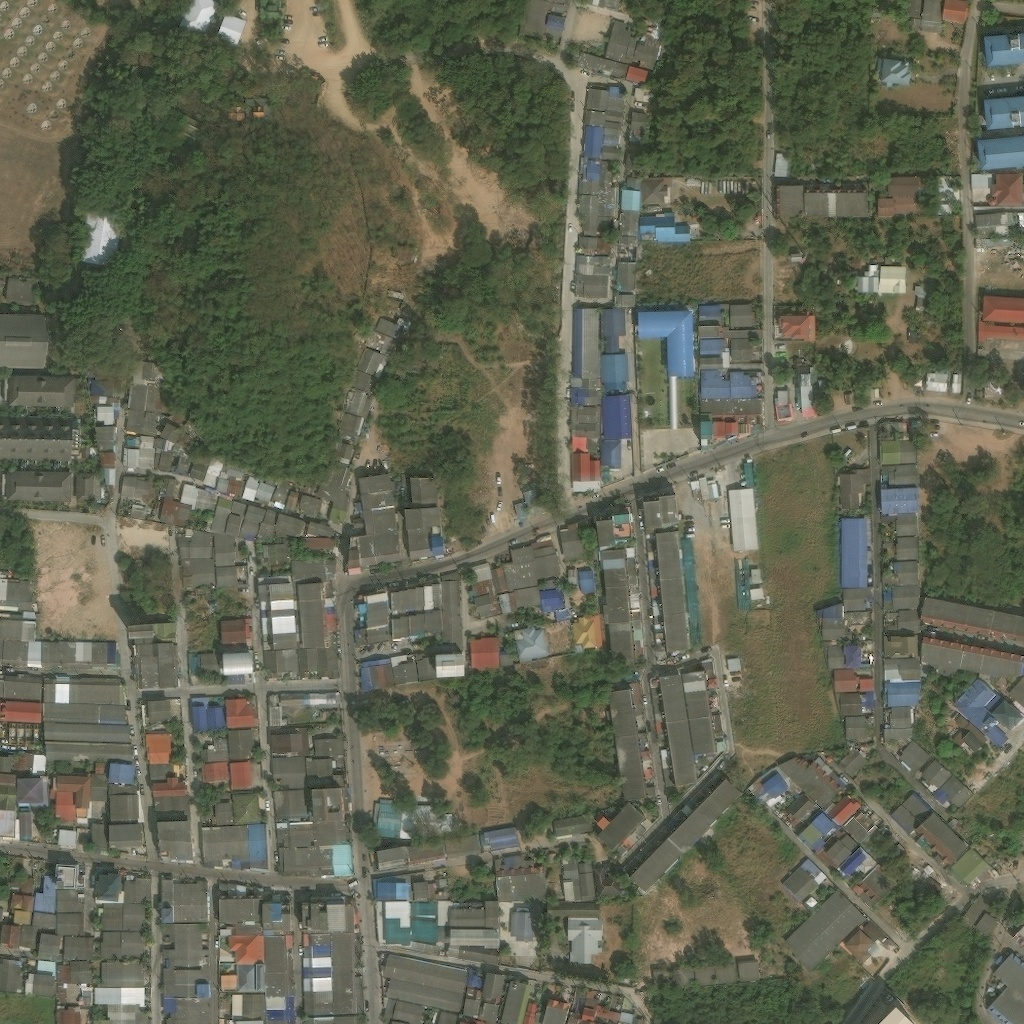

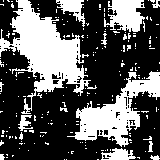

In [32]:
val_gen = Building_imgs(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 5

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.